In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from apng import APNG, PNG
from huffman import *
from helper import *
from PIL import Image
import io
from bitarray import bitarray
from TNCaprs import TNCaprs

%matplotlib inline

import sounddevice as sd
import RPi.GPIO as GPIO

# Data Compression

Choose file

42 52


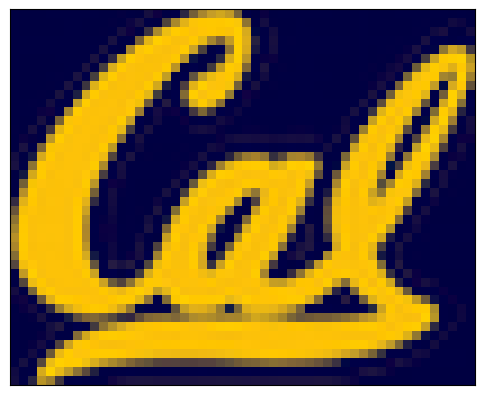

In [11]:
# Read APNG
os.system('rm -rf frames/*')
frames_folder = "frames/"
apng = APNG.open("Rolling.png")
# Save frames
frames = []
for i, (png, control) in enumerate(apng.frames):
    # png.save(frames_folder + f"{i}.png")
    frames.append(np.array(Image.open(io.BytesIO(png.to_bytes())))[:, :, 0:3])
    
M, N = frames[0].shape[0:2]
print(M, N)
# Display image
plt.figure(figsize=(6,6))
plt.imshow(frames[0]), plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
def encode_frame(png, control, quality, i):
    # Inputs: png (png obj)
    #         control (control obj, to get delay)
    #         quality (quality)
    #         i (frame num, int)
    # Returns: encoded (bitarray)
    encoded = bitarray()
    img = np.array(Image.open(io.BytesIO(png.to_bytes())))[:, :, 0:3]
    M, N = img.shape[0:2]
    
    bits = encode_image(img, quality=quality)
    
    delay = control.delay
    # Start
    encoded.pack(bytes.fromhex("FFD8"))
    # Rows, Cols
    encoded.pack(M.to_bytes(2, "big"))
    encoded.pack(N.to_bytes(2, "big"))
    # Quality
    encoded.pack(quality.to_bytes(2, "big"))
    # Delay
    encoded.pack(delay.to_bytes(1, "big"))
    # Frame num
    encoded.pack(i.to_bytes(1, "big"))
    for ba in bits:
        encoded.pack(bytes.fromhex("FFDA"))
        num_pad = (16 - (len(ba) % 16)) % 16
        ba += bitarray("1") * num_pad # pad to even number of bytes with 1s
        encoded += ba
    encoded.pack(bytes.fromhex("FFD9"))
    
    return encoded

def decode_frame(bits):
    # Input: bits
    return

In [8]:
def encode_apng(apng, fname):
    # Stores apng in file
    ba = bitarray()
    for i, (png, control) in enumerate(apng.frames):
        ba += encode_frame(png, control, 75, i)
    with open(fname, "wb") as fh:
        ba.tofile(fh)

In [9]:
encode_apng(apng, 'apng.jpeg123')

# Transmission Pipeline

Generate config

In [11]:
# Enter your address here
myaddress = "6433 Telegraph Ave Oakland CA USA"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="EE123")
location = geolocator.geocode(myaddress, timeout=None)

lat = "lat=%d^%2.2f%s" % (int(abs(location.latitude)),
                          60*(abs(location.latitude) - abs(math.floor(location.latitude))),
                          ("N") if location.latitude >0 else "S" )  
long = "long=%d^%2.2f%s" % (int(abs(location.longitude)),
                            60*(abs(location.longitude) - math.floor(abs(location.longitude))),
                          ("W") if location.longitude <0 else "E" )  

# enter your callsign and comment for the beacon
callsign = "EE1235-1"
comment = "git"

# generate passcode
callsignr = callsign.split('-')[0].upper()
code = 0x73e2
for i, char in enumerate(callsignr):
    code ^= ord(char) << (8 if not i % 2 else 0)

passcode = code & 0x7fff
print("Passcode:", passcode)

import os

cmd = "cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/"+callsign+"/g'  | "
cmd = cmd +  "sed  's/EE123_PASSCODE/%d/g' | " % (passcode)
cmd = cmd +  "sed  's/EE123_COMMENT/comment=\"%s\"/g' | " % (comment)
cmd = cmd +  "sed  's/EE123_LATCOORD/%s/g' | " % (lat)
cmd = cmd +  "sed  's/EE123_LONGCOORD/%s/g' > direwolf-loopback.conf" % (long)
print(cmd)
os.system(cmd)  # NOTE: this is poor security practice, but conveniently concise here

Passcode: 13472
cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/EE1235-1/g'  | sed  's/EE123_PASSCODE/13472/g' | sed  's/EE123_COMMENT/comment="git"/g' | sed  's/EE123_LATCOORD/lat=37^51.05N/g' | sed  's/EE123_LONGCOORD/long=122^15.65W/g' > direwolf-loopback.conf


0

Devices

In [17]:
builtin_idx = 0
usb_idx = 1
loop_idx = 3  # Use loopback dev 1! direwolf is connected to dev 0.
loop_idx_rcv = 2 # Use loopback dev 0. 
sd.default.samplerate = 48000
sd.default.channels = 1

TNC

In [19]:
# Convert from bitarray class to b64 bytes and back
def ee123_bitarr_to_base64(bits: bitarray.bitarray):
    bN = np.uint32(len(bits)).tobytes()
    mybytes = bN + bits.tobytes()
    return base64.b64encode(mybytes)

def ee123_base64_to_bitarr(b64: str):
    mybytes = base64.b64decode(b64)  # Be careful not to overwrite the builtin bytes class!
    N = np.frombuffer(mybytes[:4], dtype='<u4')[0]
    ba = bitarray.bitarray()
    ba.frombytes(mybytes[4:])
    return ba[:N]

def file_to_b64(fname):
    with open(fname, 'rb') as f:
        raw = f.read()
    # Prepend the number of bytes before encoding
    b64 = base64.b64encode(np.uint32(len(raw)).tobytes() + raw)
    return b64

def enqueue_data(callsign, modem, data, address=None, uid=None, fname="myfile.bin", 
                 comment="UCB EE123 message format", dest=b"APCAL", bsize=240):
    """
    Inputs:
      callsign: your callsign
      modem: a modem object
      data: data to send as a bytes object
      address: address callsign for the message, defaults to your callsign
      uid: optionally specify a UID, otherwise one will be randomly chosen
      fname: filename to send in start packet
      comment: comment for start packet
      dest: should be APCAL for EE123 data
      bsize: number of bytes to send per packet
      
    Outputs:
      Qout: a queue containing modulated packets to transmit
      uid: the uid used for this data transfer
    """
    if address is None:
        address = callsign
    if uid is None:
        uid = np.random.randint(0, 10000)
    uid = bytes("{:04d}".format(uid), 'utf-8')
    print("Putting packets in Queue for transmission ID=%s" % uid.decode())
    
    Qout = Queue.Queue()
    
    Digi = b'WIDE1-1'

    # Enqueue START packet
    addr = bytes(':{:<9}:'.format(address), 'utf-8')
    # addr, START, uid, filename, comment
    start = b','.join([addr + b'START' + uid, bytes(fname, 'utf-8'), bytes(comment, 'utf-8')])
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=start)
    Qout.put(tmp)
    # Enqueue data packets
    idx = 0
    while True:
        seq = bytes('{:04d}'.format(idx), 'utf-8')
        info = addr + data[idx*bsize:idx*bsize+bsize] + seq
        tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=info)
        Qout.put(tmp)
        
        idx += 1
        if idx * bsize > len(data):
            break
    # Enqueue END packet
    end = addr + b'END' + uid
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=end)
    Qout.put(tmp)

    return Qout, uid

In [36]:
callsign = "EE1235-1"
fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)
fname = "apng.jpeg123"

print("Putting packets in Queue")

# Enqueue the file
file_b64 = file_to_b64(fname)
Qout, uid = enqueue_data(
    callsign,
    modem,
    file_b64,
    fname=fname
)

print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")

In [13]:
# Define the callback factory so we can specify which non-global queue we want
def make_QR_callback(Qin):
    def queueREPLAY_callback(indata, outdata, frames, time, status):
#         assert frames == 1024
        if status:
            print(status)
        outdata[:] = indata
        Qin.put(indata.copy()[:, 0]) # Global queue
    return queueREPLAY_callback

In [14]:
Qin = Queue.Queue()
# This stream captures samples on loopback_rcv and plays them on the built in device.
# Remember that loopback is connected to loopback_rcv.
st_replay = sd.Stream(device=(loop_idx_rcv, builtin_idx), blocksize=modem.Abuffer, callback=make_QR_callback(Qin))
print("Starting stream")
st_replay.start()
starttime = time.time()

N = Qout.qsize()
n = 0
while not Qout.empty():
    n = n+1
    tmp = Qout.get()
    time.sleep(0.1)
    sd.play(0.4*tmp,samplerate=fs,blocking=True,device=loop_idx)
    print("played packet #%d of %d" % (n,N))    

# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

print(f"Done: {time.time() - starttime:.2f} s")
print(f"There are {Qin.qsize()} buffers in Qin")

NameError: name 'Queue' is not defined

In [15]:
# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

NameError: name 'st_replay' is not defined

In [16]:
def decode_ee123_message(msg):
    """
    Input:
      msg: The info field of an APRS message packet
    
    Output:
      A dict containing the key components the packet may contain
      
    Message formats:
    :CALLSIGN :START####,filename,comment
    :CALLSIGN :<data data data>####
    :CALLSIGN :END####
    """
    msg = msg.strip()
    addressee = ''
    uid = None
    isstart = False
    isend = False
    seq = None
    data = None  # This should be a bytes object
    filename = ''
    comment = ''
    
    # Your code here:
    # First item is empty due to space
    msg = msg.split(":")[1:]
    # Callsign
    addressee = msg.pop(0)
    # Check start, end, or data
    msg_type = msg.pop(0)
    
    if msg_type.find("START") >= 0:
        isstart = True
        uid = msg_type[-4:]
        body = msg_type.split(',')
        body.pop(0)
        filename = body.pop(0)
        comment = body.pop(0)
    elif msg_type.find("END") >= 0:
        isend = True
        uid = msg_type[-4:]
    else:
        # Data Type
        b64dat = msg_type[0:-4]
        seq = msg_type[-4:]
        data = base64.b64decode(b64dat)

    # End of your code
    return {'addr': addressee, 'uid': uid, 'isstart': isstart, 
            'isend': isend, 'seq': seq, 'filename': filename, 
            'data': data, 'comment': comment}

In [17]:
# Decode the recording
print("decoding packets")
starttime = time.time()

# Your code here:
msg = []
while not Qin.empty():
    tmp = Qin.get()
    packets = modem.processBuffer(tmp)
    for pckt in packets:
        ax = modem.decodeAX25(pckt)
        print(ax.info)
        msg.append(decode_ee123_message(ax.info))

decoding packets


NameError: name 'Qin' is not defined

In [ ]:
data = [m for m in msg if not (m['isstart'] or m['isend'])]
data_sorted = sorted(data, key=lambda d: int(d['seq'], 16))
binary = b''.join([d['data'] for d in data_sorted])[4:]
rec_fname = "rec_" + [m['filename'] for m in msg if m['isstart']][0]
print(rec_fname)

# End of your code
# Save the reconstructed file
with open(rec_fname, 'wb') as f:
    f.write(binary)

print(f"Done: {time.time() - starttime:.2f} s")